In [1]:
%matplotlib inline

import numpy as np 
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt 
import sklearn
import seaborn as sns
import mlflow 
import mlflow.sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, plot_roc_curve, confusion_matrix 
import warnings
warnings.filterwarnings('ignore')

print(f"numpy version {np.__version__}")
print(f"pandas version {pd.__version__}")
print(f"matplotlib version {mpl.__version__}")
print(f"seaborn version {sns.__version__}")
print(f"sklearn version {sklearn.__version__}")
print(f"MLFlow version {mlflow.__version__}")

numpy version 1.23.1
pandas version 1.4.3
matplotlib version 3.5.2
seaborn version 0.11.2
sklearn version 1.1.1
MLFlow version 1.27.0


# 데이터 불러오기

In [2]:
import os

# print(os.getcwd())
DATA_PATH = 'C:\\Users\\human\\Desktop\\mlops_sam\\data\\sales_forecast\\'

train_df = pd.read_csv(DATA_PATH + 'train.csv')
test = pd.read_csv(DATA_PATH + 'test.csv')
submission = pd.read_csv(DATA_PATH + 'sample_submission.csv')

train_df.shape, test.shape, submission.shape

((6255, 13), (180, 12), (180, 2))

In [3]:
# train 데이터세트의 정보 확인
print(train_df.info())
print(train_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6255 entries, 0 to 6254
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            6255 non-null   int64  
 1   Store         6255 non-null   int64  
 2   Date          6255 non-null   object 
 3   Temperature   6255 non-null   float64
 4   Fuel_Price    6255 non-null   float64
 5   Promotion1    2102 non-null   float64
 6   Promotion2    1592 non-null   float64
 7   Promotion3    1885 non-null   float64
 8   Promotion4    1819 non-null   float64
 9   Promotion5    2115 non-null   float64
 10  Unemployment  6255 non-null   float64
 11  IsHoliday     6255 non-null   bool   
 12  Weekly_Sales  6255 non-null   float64
dtypes: bool(1), float64(9), int64(2), object(1)
memory usage: 592.6+ KB
None
   id  Store        Date  Temperature  Fuel_Price  Promotion1  Promotion2  \
0   1      1  05/02/2010        42.31       2.572         NaN         NaN   
1   2      1  12

In [4]:
# test 데이터세트의 정보 확인
print(test.info())
print(test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            180 non-null    int64  
 1   Store         180 non-null    int64  
 2   Date          180 non-null    object 
 3   Temperature   180 non-null    float64
 4   Fuel_Price    180 non-null    float64
 5   Promotion1    178 non-null    float64
 6   Promotion2    45 non-null     float64
 7   Promotion3    161 non-null    float64
 8   Promotion4    146 non-null    float64
 9   Promotion5    180 non-null    float64
 10  Unemployment  180 non-null    float64
 11  IsHoliday     180 non-null    bool   
dtypes: bool(1), float64(8), int64(2), object(1)
memory usage: 15.8+ KB
None
   id  Store        Date  Temperature  Fuel_Price  Promotion1  Promotion2  \
0   1      1  05/10/2012        68.55       3.617     8077.89         NaN   
1   2      1  12/10/2012        62.99       3.601     2086.18 

In [5]:
train_df['Date'].value_counts()
# 쇼핑몰 매장별 기록된 프로모션 일이 총 139일

05/02/2010    45
02/12/2011    45
21/10/2011    45
28/10/2011    45
04/11/2011    45
              ..
12/11/2010    45
05/11/2010    45
29/10/2010    45
22/10/2010    45
28/09/2012    45
Name: Date, Length: 139, dtype: int64

In [6]:
train_df.Store.value_counts()
# 쇼핑몰 매장 갯수 45개

1     139
24    139
26    139
27    139
28    139
29    139
30    139
31    139
32    139
33    139
34    139
35    139
36    139
37    139
38    139
39    139
40    139
41    139
42    139
43    139
44    139
25    139
23    139
2     139
22    139
3     139
4     139
5     139
6     139
7     139
8     139
9     139
10    139
11    139
12    139
13    139
14    139
15    139
16    139
17    139
18    139
19    139
20    139
21    139
45    139
Name: Store, dtype: int64

# 결측치 확인

In [7]:
# Train 데이터세트의 전체 컬럼의 결측치 확인
train_df.isnull().sum()

id                 0
Store              0
Date               0
Temperature        0
Fuel_Price         0
Promotion1      4153
Promotion2      4663
Promotion3      4370
Promotion4      4436
Promotion5      4140
Unemployment       0
IsHoliday          0
Weekly_Sales       0
dtype: int64

<AxesSubplot:>

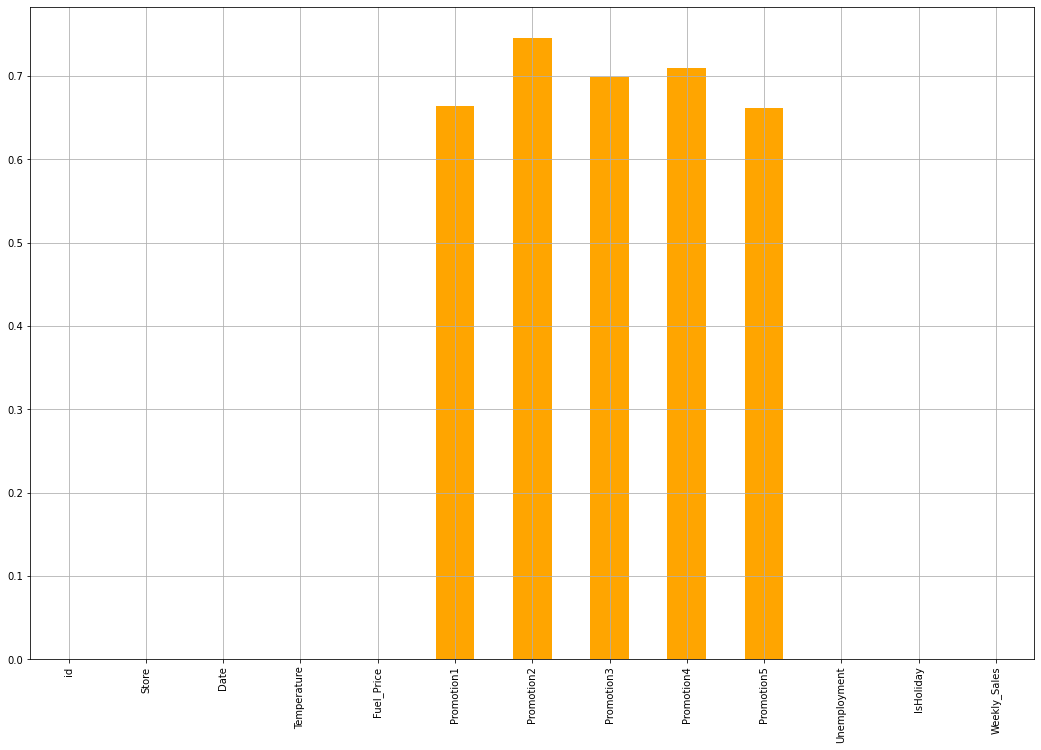

In [8]:
train_df.isnull().mean().plot(kind = 'bar', figsize = (18, 12), grid = True, color = 'orange', linewidth = 4)

- 프로모션1,2,3,4,5에 많은 결측치가 있다는 것을 확인할 수 있다.
- 그렇다면 매장별 프로모션에는 어느 정도의 결측치가 있을까? 이를 확인하고자 한다.

In [16]:
Prom = ['Promotion1', 'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5']

for a in range(1, 46):
    print('Store {}의 NaN 퍼센트 : '.format(a))
    print(100 * np.round(train_df[train_df['Store'] == a][Prom].isnull().sum()/139, 4), '\n')

Store 1의 NaN 퍼센트 : 
Promotion1    66.19
Promotion2    70.50
Promotion3    66.91
Promotion4    66.19
Promotion5    66.19
dtype: float64 

Store 2의 NaN 퍼센트 : 
Promotion1    66.19
Promotion2    70.50
Promotion3    66.91
Promotion4    66.19
Promotion5    66.19
dtype: float64 

Store 3의 NaN 퍼센트 : 
Promotion1    66.19
Promotion2    72.66
Promotion3    71.22
Promotion4    67.63
Promotion5    66.19
dtype: float64 

Store 4의 NaN 퍼센트 : 
Promotion1    66.19
Promotion2    69.78
Promotion3    67.63
Promotion4    66.19
Promotion5    66.19
dtype: float64 

Store 5의 NaN 퍼센트 : 
Promotion1    66.19
Promotion2    74.10
Promotion3    70.50
Promotion4    66.91
Promotion5    66.19
dtype: float64 

Store 6의 NaN 퍼센트 : 
Promotion1    66.19
Promotion2    69.06
Promotion3    66.91
Promotion4    66.19
Promotion5    66.19
dtype: float64 

Store 7의 NaN 퍼센트 : 
Promotion1    66.19
Promotion2    74.10
Promotion3    67.63
Promotion4    66.19
Promotion5    66.19
dtype: float64 

Store 8의 NaN 퍼센트 : 
Promotion1    66.19
P

- 편차가 있긴 하지만 매장별로 프로모션의 결측치가 약 67퍼센트 정도에 달한다.

In [23]:
train_df[train_df['Store'] == 1].loc[70:120]

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
70,71,1,10/06/2011,83.13,3.648,NaN,NaN,NaN,NaN,NaN,7.682,False,1588948.32
71,72,1,17/06/2011,86.41,3.637,NaN,NaN,NaN,NaN,NaN,7.682,False,1532114.86
72,73,1,24/06/2011,83.58,3.594,NaN,NaN,NaN,NaN,NaN,7.682,False,1438830.15
73,74,1,01/07/2011,85.55,3.524,NaN,NaN,NaN,NaN,NaN,7.962,False,1488538.09
74,75,1,08/07/2011,85.83,3.480,NaN,NaN,NaN,NaN,NaN,7.962,False,1534849.64
75,76,1,15/07/2011,88.54,3.575,NaN,NaN,NaN,NaN,NaN,7.962,False,1455119.97
76,77,1,22/07/2011,85.77,3.651,NaN,NaN,NaN,NaN,NaN,7.962,False,1396926.82
77,78,1,29/07/2011,86.83,3.682,NaN,NaN,NaN,NaN,NaN,7.962,False,1352219.79
78,79,1,05/08/2011,91.65,3.684,NaN,NaN,NaN,NaN,NaN,7.962,False,1624383.75
79,80,1,12/08/2011,90.76,3.638,NaN,NaN,NaN,NaN,NaN,7.962,False,1525147.09


In [25]:
train_df[train_df['Store'] == 2].loc[220:]

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
220,221,2,26/08/2011,90.45,3.523,NaN,NaN,NaN,NaN,NaN,7.852,False,1821139.91
221,222,2,02/09/2011,89.64,3.533,NaN,NaN,NaN,NaN,NaN,7.852,False,1809119.70
222,223,2,09/09/2011,77.97,3.546,NaN,NaN,NaN,NaN,NaN,7.852,True,1748000.65
223,224,2,16/09/2011,78.85,3.526,NaN,NaN,NaN,NaN,NaN,7.852,False,1691439.52
224,225,2,23/09/2011,75.58,3.467,NaN,NaN,NaN,NaN,NaN,7.852,False,1669299.78
225,226,2,30/09/2011,78.14,3.355,NaN,NaN,NaN,NaN,NaN,7.852,False,1650394.44
226,227,2,07/10/2011,69.92,3.285,NaN,NaN,NaN,NaN,NaN,7.441,False,1837553.43
227,228,2,14/10/2011,71.67,3.274,NaN,NaN,NaN,NaN,NaN,7.441,False,1743882.19
228,229,2,21/10/2011,64.53,3.353,NaN,NaN,NaN,NaN,NaN,7.441,False,1834680.25
229,230,2,28/10/2011,65.87,3.372,NaN,NaN,NaN,NaN,NaN,7.441,False,1769296.25


In [28]:
train_df[train_df['Store'] == 3].loc[360:]

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
360,361,3,02/09/2011,89.12,3.533,NaN,NaN,NaN,NaN,NaN,7.567,False,375988.69
361,362,3,09/09/2011,81.72,3.546,NaN,NaN,NaN,NaN,NaN,7.567,True,377347.49
362,363,3,16/09/2011,83.63,3.526,NaN,NaN,NaN,NaN,NaN,7.567,False,375629.51
363,364,3,23/09/2011,80.19,3.467,NaN,NaN,NaN,NaN,NaN,7.567,False,365248.94
364,365,3,30/09/2011,82.58,3.355,NaN,NaN,NaN,NaN,NaN,7.567,False,368477.93
365,366,3,07/10/2011,75.54,3.285,NaN,NaN,NaN,NaN,NaN,7.197,False,403342.40
366,367,3,14/10/2011,73.75,3.274,NaN,NaN,NaN,NaN,NaN,7.197,False,368282.57
367,368,3,21/10/2011,69.03,3.353,NaN,NaN,NaN,NaN,NaN,7.197,False,394976.36
368,369,3,28/10/2011,71.04,3.372,NaN,NaN,NaN,NaN,NaN,7.197,False,389540.62
369,370,3,04/11/2011,59.31,3.332,NaN,NaN,NaN,NaN,NaN,7.197,False,459443.22


### 프로모션이 2011년 11월 11일부터 시행되어 그 전에는 시행되지 않은 것으로 볼 수 있다.

## 결측치 처리

### 여기서 두 가지 방법을 해보고자 한다
    - 첫째, 프로모션의 결측치를 모두 0으로 처리
    - 둘째, 2011년 11월 11일 이전의 프로모션 데이터는 모두 0으로 대치하고, 프로모션 시행 기간 안에 있는 결측치는 선형보간법으로 대치

### 프로모션의 결측치를 모두 0으로 처리

In [31]:
train_df = train_df.fillna(0)

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
0,1,1,05/02/2010,42.31,2.572,0.0,0.0,0.0,0.0,0.0,8.106,False,1643690.90
1,2,1,12/02/2010,38.51,2.548,0.0,0.0,0.0,0.0,0.0,8.106,True,1641957.44
2,3,1,19/02/2010,39.93,2.514,0.0,0.0,0.0,0.0,0.0,8.106,False,1611968.17
3,4,1,26/02/2010,46.63,2.561,0.0,0.0,0.0,0.0,0.0,8.106,False,1409727.59
4,5,1,05/03/2010,46.50,2.625,0.0,0.0,0.0,0.0,0.0,8.106,False,1554806.68


In [33]:
train_df.isnull().sum()

id              0
Store           0
Date            0
Temperature     0
Fuel_Price      0
Promotion1      0
Promotion2      0
Promotion3      0
Promotion4      0
Promotion5      0
Unemployment    0
IsHoliday       0
Weekly_Sales    0
dtype: int64

## 상관관계 분석

### 1개 매장별 상관관계

<Figure size 1800x1800 with 0 Axes>

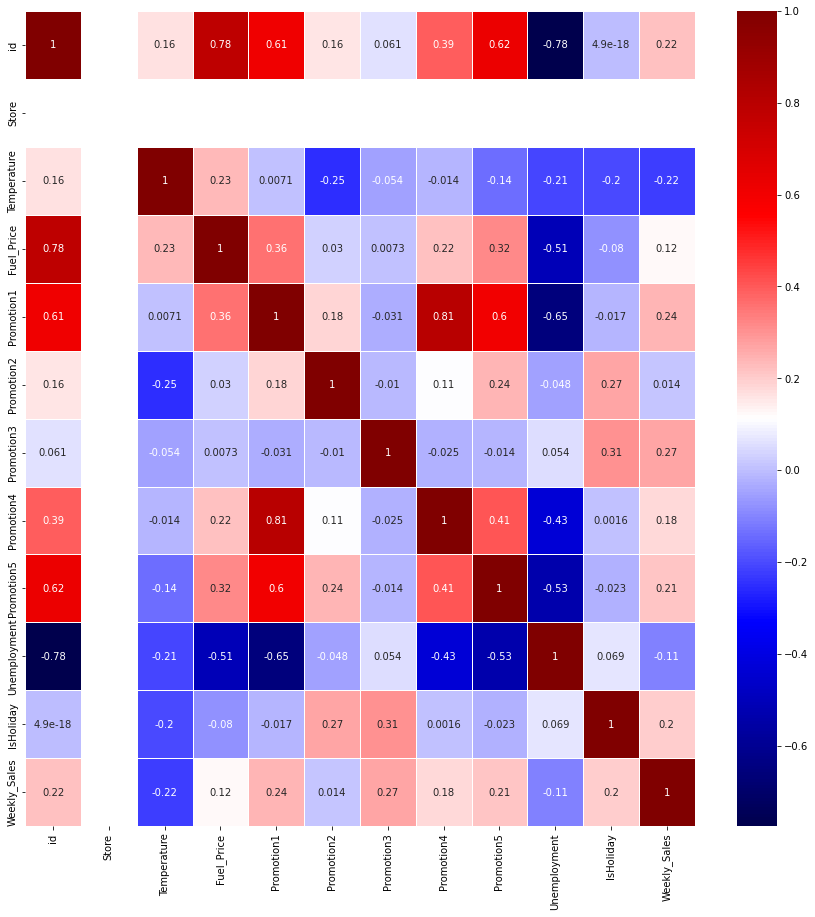

In [58]:
# 1번 매장의 상관관계 분석
from matplotlib import dates
fig = plt.figure(figsize = (25, 25))

for x in range(1, 2):
    train_t = train_df[train_df['Store'] == x]
    plt.figure(figsize = (15, 15))
    sns.heatmap(data = train_t.corr(), annot = True, linewidth = 1, cmap = 'seismic');